# Cipher Decryption

A substitution cipher decryption algorithm using Natural Language Processing and Genetic Algorithm.

## Necessary Imports

In [0]:
import re
import string
import requests
import textwrap
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## Substitution Cipher

In [0]:
class SubstitutionCipher:
  def __init__(self):
    # attributes  
    self.mapping_dict = {}
    self.alphabet_set_1 = list(string.ascii_lowercase)
    self.alphabet_set_2 = list(string.ascii_lowercase)

  def __call__(self):
    # shuffle unigrams in second alphabet set   
    random.shuffle(self.alphabet_set_2)

    # create substitution mapping dictionary
    for key, value in zip(self.alphabet_set_1, self.alphabet_set_2):
      self.mapping_dict[key] = value 

    return self.mapping_dict  

## Language Model

In [0]:
class LanguageModel:
  def __init__(self):
    # create a markov matrix (26 alphabets)  
    self.markov_matrix = np.ones((26, 26)) 
    # create pi vector with 26 zeros (26 alphabets) which would be our initial state distribution
    self.pi = np.zeros(26)

  # update markov matrix
  def updateTransition(self, bigram_char_1, bigram_char_2):
    i = ord(bigram_char_1) - 97
    j = ord(bigram_char_2) - 97  
    self.markov_matrix[i, j] += 1

  # update state distribution
  def updatePi(self, unigram_char):
    i = ord(unigram_char) - 97  
    self.pi[i] += 1

  # get log probability of a token
  def getWordProbability(self, word):
    i = ord(word[0]) - 97
    log_probability = np.log(self.pi[i])

    for char in word[1:]:
      j = ord(char) - 97
      log_probability += np.log(self.markov_matrix[i, j])
      i = j

    return log_probability 

  # get log probability of a sequence of tokens
  def getSequenceProbability(self, sequence):
    if type(sequence) == str:
      words = sequence.split()

    log_probability = 0

    for word in words:
      log_probability += self.getWordProbability(word)

    return log_probability     

## Cipher 

In [0]:
class Cipher:
  def __init__(self):
    # attributes  
    self.regex = re.compile('[^a-zA-Z]')
    self.language_model = LanguageModel()
    self.substitution_cipher = SubstitutionCipher()
    self.true_mapping = self.substitution_cipher()
    self.dna_pool = []
    self.scores = None
    self.best_dna = None
    self.best_map = None
    self.best_score = float('-inf')

    # create initial dna pool randomly for our genetic algorithm
    for _ in range(20):
      dna = list(string.ascii_lowercase)
      random.shuffle(dna)
      self.dna_pool.append(dna)

    # create markov model based on an English text dataset
    # read line by line
    for line in open('scraped_text.txt', encoding='utf8'):
      # read a line  
      line = line.rstrip()  

      if line:
        # replace all non-alphabetic characters with space  
        line = self.regex.sub(' ', line)
        
        # split lines into words => tokens
        tokens = line.lower().split() # convert to lowercase and split

        # process token by token
        for token in tokens:
          # first letter of the token/word = a unigram  
          unigram = token[0]
          # update state distribution with the unigram
          self.language_model.updatePi(unigram)

          # update markov matrix by creating bigrams with first letter unigram and following letters in that token  
          for letter in token[1:]:
            self.language_model.updateTransition(unigram, letter)
            unigram = letter

    # normalize state distribution and markov matrix
    self.language_model.pi /= self.language_model.pi.sum()
    self.language_model.markov_matrix /= self.language_model.markov_matrix.sum(axis=1, keepdims=True)

  #  encrypt a given message using Substitution Cipher's mapping dictionary
  def encrypt(self, message):
    # convert text to lowercase  
    message = message.lower()

    # replace non-alphabetic characters with space
    message = self.regex.sub(' ', message)

    # empty buffer for storing encypted message letter by letter
    encrypted_message = []

    # substitute each unigram in a token of tokens present in the message with a value from mapping dictionary
    for char in message:
      encoded_char = char
      
      if char in self.true_mapping:
        encoded_char = self.true_mapping[char]
      
      encrypted_message.append(encoded_char)

    return ''.join(encrypted_message)

  # decrypt given message using specified dictionary
  def decrypt(self, message, word_mapping):
    # empty buffer for storing decrypted message
    decrypted_message = []
    
    # decode by mapping unigrams with values present in the given mapping dictionary
    for char in message:
      decoded_char = char
      
      if char in word_mapping:
        decoded_char = word_mapping[char]
      
      decrypted_message.append(decoded_char)

    return ''.join(decrypted_message)

  # perform an evolution by creating n childrens per parent
  def evolve_offspring(self, dna_pool, num_children):
    offspring = []

    # perform swapping of unigrams in dna to get updated dna
    for dna in dna_pool:
      for _ in range(num_children):
        clone = dna.copy()
        j = np.random.randint(len(clone))
        k = np.random.randint(len(clone))

        temp = clone[j]
        clone[j] = clone[k]
        clone[k] = temp

        offspring.append(clone)

    # return updated dna pool 
    return offspring + dna_pool     

  # train the genetic algorithm for specified epochs to decrypt the message by finding best log likelihood
  def fit(self, message, epochs, metrics=False):    
    self.scores = np.zeros(epochs)

    for epoch in range(epochs):
      if epoch>0:
        # get updated dna pool by performing an evolution  
        self.dna_pool = self.evolve_offspring(self.dna_pool, 3)

      # calculate log likelihood for each dna present in dna pool
      dna_score = {}

      for dna in self.dna_pool:
        # create or update the decryption mapping dictionary with unigrams of a dna  
        current_mapping = {}

        for key, value in zip(self.substitution_cipher.alphabet_set_1, dna):
          current_mapping[key] = value

        # decrypt the given message with newly populated decyrption mapping dictionary
        decoded_message = self.decrypt(message, current_mapping)

        # get log likelihood for latest decrypted message
        score = self.language_model.getSequenceProbability(decoded_message)

        # update dna score of each dna with its log likelihood
        dna_score[''.join(dna)] = score

        # replace best dna, decryption mapping dictionary and log likelihood score if new score is greater than old score
        if score > self.best_score:
          self.best_dna = dna
          self.best_map = current_mapping
          self.best_score = score

      # update overall log likelihood per dna pool process with the mean of dna scores
      self.scores[epoch] = np.mean(list(dna_score.values()))

      # sort the dna's based on its score
      sorted_dna = sorted(dna_score.items(), key = lambda x: x[1], reverse=True)

      # update dna pool with only the first five fittest dna's
      self.dna_pool = [list(key) for key, value in sorted_dna[:5]]

      # display training metrics
      if (epoch % 100 == 0 or epoch==0 or epoch==999) and metrics==True:
        print("Epoch {}".format(epoch+1))     
        print("Log Likelihood : {:.4f}  |  Optimal Log Likelihood : {:.4f}".format(self.scores[epoch], self.best_score))

    # decrypt the given message with the best decryption mapping dictionary after genetic algorithm gets completely trained
    decrypted_msg = self.decrypt(message, self.best_map)
    
    # display decrypted message's best log likelihood
    if metrics==True:
      print("\nLog Likelihood of Decrypted Message: {:.4f}".format(self.language_model.getSequenceProbability(decrypted_msg)))

    # display decrypted message
    print("\nDecrypted Message\n\n{}\n".format(textwrap.fill(decrypted_msg)))

## Train for decryption

Instantiate the Cipher class

In [0]:
cipher = Cipher()

Define an input message

In [6]:
my_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

print("Original Message\n\n{}".format(my_message))

Original Message

I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.



Encrypt the input message

In [7]:
encrypted_message = cipher.encrypt(my_message)
print("Encrypted Message\n\n{}".format(textwrap.fill(encrypted_message)))

Encrypted Message

x yesh tgrhlsm mgwh yes cyassy vhm ogrhm  vc x sfiskysm  yevy yesas
wvc v jswc xh v tvhs wexke arhc mgwh bn ghs wvtt go yes lvamsh  x tshy
yes gcytsac v evhm xh arbbxhl mgwh yesxa egacsc  vhm asksxdsm xh
sfkevhls ywgishks  v ltvcc go evto vhm evto  ywg oxttc go cevl ygbvkkg
vhm vc jrke xhogajvyxgh vc x kgrtm mscxas vbgry jxcc vmtsa  yg cvn
hgyexhl go evto v mgpsh gyesa isgits xh yes hsxlebgraeggm xh wegj x
wvc hgy xh yes tsvcy xhysascysm  bry wegcs bxglaviexsc x wvc kgjisttsm
yg txcysh yg


Train the Genetic Algorithm for 1000 iterations to achieve maximum log likelihood for best decryption by finding best mapping unigrams for the encrypted message

In [8]:
cipher.fit(encrypted_message, epochs=1000, metrics=True)

Epoch 1
Log Likelihood : -2044.1600  |  Optimal Log Likelihood : -1709.4830
Epoch 101
Log Likelihood : -1082.6971  |  Optimal Log Likelihood : -1014.4706
Epoch 201
Log Likelihood : -1058.3945  |  Optimal Log Likelihood : -933.0312
Epoch 301
Log Likelihood : -1034.7419  |  Optimal Log Likelihood : -929.5903
Epoch 401
Log Likelihood : -1048.4437  |  Optimal Log Likelihood : -929.5903
Epoch 501
Log Likelihood : -1001.7790  |  Optimal Log Likelihood : -929.5903
Epoch 601
Log Likelihood : -1019.0806  |  Optimal Log Likelihood : -929.5903
Epoch 701
Log Likelihood : -1005.0562  |  Optimal Log Likelihood : -929.5903
Epoch 801
Log Likelihood : -1019.7447  |  Optimal Log Likelihood : -929.5903
Epoch 901
Log Likelihood : -1017.9152  |  Optimal Log Likelihood : -929.5903
Epoch 1000
Log Likelihood : -1015.3311  |  Optimal Log Likelihood : -929.5903

Log Likelihood of Decrypted Message: -929.5903

Decrypted Message

i then lounged down the street and found  as i expected  that there
was a mews in a 

## Evaluation

### Log Likelihood score graph

We can clearly see that we've achieved maximum likelihood (Gradient Ascent)

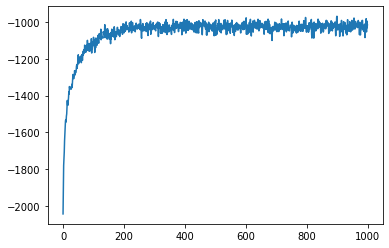

In [9]:
plt.plot(cipher.scores)
plt.show() 

### False mappings

Only 3 unigrams have been falsely predicted during decryption

In [10]:
for true, value in cipher.true_mapping.items():
  pred = cipher.best_map[value]
  if true != pred:
    print("Original: {}, Predicted: {}".format(true, pred))

Original: j, Predicted: z
Original: k, Predicted: j
Original: z, Predicted: k
